# Automathon 2024

In [1]:
# !pip install pyav

   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   -----------------

In [2]:
# !pip install torchinfo

In [3]:
# !pip install timm

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
    --------------------------------------- 0.0/2.2 MB 279.3 kB/s eta 0:00:08
    --------------------------------------- 0.0/2.2 MB 279.3 kB/s eta 0:00:08
    --------------------------------------- 0.0/2.2 MB 279.3 kB/s eta 0:00:08
   - -------------------------------------- 0.1/2.2 MB 245.8 kB/s eta 0:00:09
   - -------------------------------------- 0.1/2.2 MB 245.8 kB/s eta 0:00:09
   - -------------------------------------- 0.1/2.2 MB 218.5 kB/s eta 0:00:10
   - -------------------------------------- 0.1/2.2 MB 218.5 kB/s eta 0:00:10
   - -------------------------------------- 0.1/2.2 MB 218.5 kB/s eta 0:00:10
   -- ------------------------------------- 0.1/2.2 MB 198.4 kB/s eta 0:00:11
   -- ------------------------------------- 0.1/2.2 MB 198.4 kB/s eta 0:00:11
   -- -------

## Imports

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb
import time

from PIL import Image
import torchvision.transforms as transforms

## Utilities

In [5]:
import matplotlib.pyplot as plt

def display_image(img):
    img = img.permute(1,2,0)
    plt.imshow(img)
    
def extract_frames(video_path, nb_frames=10, delta=1, timeit=False):
    # use time to measure the time it takes to resize a video
    t1 = time.time()
    reader = io.VideoReader(video_path)
    # take 10 frames uniformly sampled from the video
    frames = []
    for i in range(0,nb_frames,delta):
        frame = next(reader)
        frames.append(frame['data'])
    t2 = time.time()     
    video = torch.stack(frames)
    if timeit:
        print(f"read: {t2-t1}")
    return video

def smart_resize(data, size): # kudos louis
    # Prends un tensor de shape [...,C,H,W] et le resize en [...C,size,size]
    # x, y, height et width servent a faire un crop avant de resize

    full_height = data.shape[-2]
    full_width = data.shape[-1]

    if full_height > full_width:
        alt_height = size
        alt_width = int(full_width / (full_height / size))
    elif full_height < full_width:
        alt_height = int(full_height / (full_width / size))
        alt_width = size
    else:
        alt_height = size
        alt_width = size
    tr = transforms.Compose([
        transforms.Resize((alt_height, alt_width)),
        transforms.CenterCrop(size)
    ])
    return tr(data)

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    # Prends un tensor de shape [...,C,H,W] et le resize en [...,C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize
    
    full_height = data.shape[-2]
    full_width = data.shape[-1]
    height = full_height - y if height is None else height
    width = full_width -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    else:
        expand_height = height
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    x = data[...,y:min(y+height, full_height), x:min(x+width, full_width)].clone()
    return tr(x)

## test

## Setup du Dataset

In [6]:

dataset_dir = "/kaggle/input/automathon-deepfake"
root_dir = os.path.expanduser("/kaggle/input/automathon-deepfake/dataset/experimental_dataset")

nb_frames = 10

class VideoDataset(Dataset):
    """
    This Dataset takes a video and returns a tensor of shape [10, 3, 256, 256]
    That is 10 colored frames of 256x256 pixels.
    """
    def __init__(self, root_dir, dataset_choice="train", nb_frames=10):
        super().__init__()
        self.dataset_choice = dataset_choice
        if  self.dataset_choice == "test":
            self.root_dir = os.path.join("datasets", "test_dataset")
        elif  self.dataset_choice == "experimental":
            self.root_dir = os.path.join("datasets", "experimental_dataset")
        else:
            raise ValueError("choice must be 'test' or 'experimental'")

        with open(os.path.join("datasets","dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            # read dataset.csv with id,label columns to create
            # a dict which associated label: id
            self.ids = {row[1] : row[0] for row in reader}

        if self.dataset_choice == "test":
            self.data = None
        else:
            with open(os.path.join(self.root_dir, "metadata.json"), 'r') as file:
                self.data= json.load(file)
                self.data = {k : (torch.tensor(float(1)) if v == 'fake' else torch.tensor(float(0))) for k, v in self.data.items()}

        self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]
        #self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.pt')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        #video, audio, info = io.read_video(video_path, pts_unit='sec')
        #video = torch.load(video_path)
        
        video = extract_frames(video_path)
        
        #video = video.permute(0,3,1,2)
        #length = video.shape[0]
        #video = video[[i*(length//(nb_frames)) for i in range(nb_frames)]]
        
        # resize the data into a reglar shape of 256x256 and normalize it
        video = smart_resize(video, 256) / 255
        #video = video / 255

        ID = self.ids[self.video_files[idx]]
        if self.dataset_choice == "test":
            return video, ID
        else:
            label = self.data[self.video_files[idx]]
            return video, label, ID



#train_dataset = VideoDataset(dataset_dir, dataset_choice="train", nb_frames=nb_frames)
test_dataset = VideoDataset(dataset_dir, dataset_choice="test", nb_frames=nb_frames)
experimental_dataset = VideoDataset(dataset_dir, dataset_choice="experimental", nb_frames=nb_frames)


Voici comment afficher un frame du dataset:

tensor(1.)
torch.Size([10, 3, 256, 256])


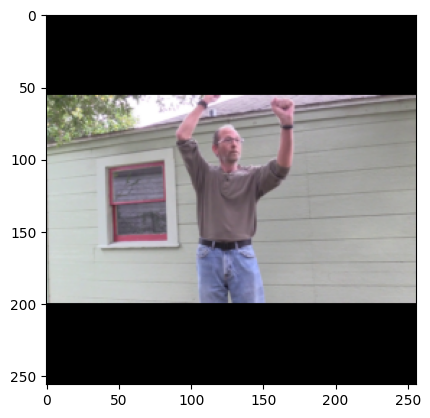

In [7]:
video, label, ID = experimental_dataset[10]
img = video[0]

display_image(img)
print(label)
print(video.shape)

torch.Size([3, 256, 256])


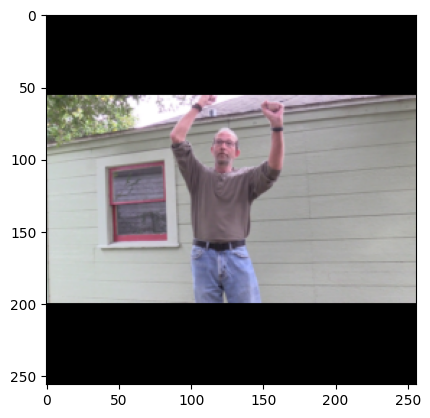

In [8]:
img = video[9]
img=smart_resize(img, 256)
print(img.shape)
display_image(img)

Et comment faire un resize

torch.Size([3, 256, 256])


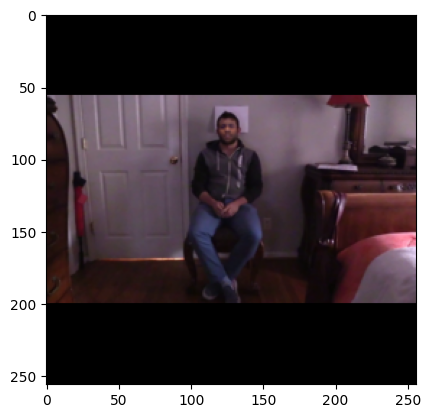

In [9]:
video, label, ID = experimental_dataset[0]
img=video[0]

img=smart_resize(img, 256)
print(img.shape)
display_image(img)

## Modèle

In [63]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*256*256,1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


model = DeepfakeDetector(nb_frames=nb_frames)
print(video.shape)
video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0) # add a batch dimension
summary(model, input_size=video.shape)

torch.Size([10, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─Sigmoid: 1-3                           [1, 1]                    --
Total params: 1,966,081
Trainable params: 1,966,081
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73

## Logging

## Entrainement

In [10]:
torch.cuda.device_count()

1

In [8]:
from torchvision.models import efficientnet_b0
import torchvision.transforms.v2 as transforms

In [65]:


    
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super(DeepfakeDetector, self).__init__()
        
        # Load pre-trained EfficientNet-B0
        self.efficientnet = efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer of EfficientNet
        self.efficientnet.classifier = nn.Identity()
        
        # Define your custom classification layers
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layer for classification
        # Calculate input size from EfficientNet and the number of frames
        input_size = nb_frames * 3 * 224 * 224
        
        self.fc = nn.Linear(input_size, 1)
        
        # Activation function (Sigmoid for binary classification)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through EfficientNet feature extractor
        features = self.efficientnet(x)
        
        # Flatten the features
        features_flattened = self.flatten(features)
        
        # Pass flattened features through fully connected layer
        logits = self.fc(features_flattened)
        
        # Apply sigmoid activation function
        predictions = self.sigmoid(logits)
        
        return predictions

In [11]:
import torchvision.transforms.v2 as transforms
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*256*256,1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.MSELoss()
#model = DeepfakeDetector().to(device)
model = DeepfakeDetector().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#epochs = 5
epochs = 1
loader = DataLoader(experimental_dataset, batch_size=10, shuffle=True)

for epoch in range(epochs):
    for sample in tqdm(loader, desc="Epoch {}".format(epoch), ncols=0):
        optimizer.zero_grad()
        X, label, ID = sample
        #X = X.to(device)
        #label = label.to(device)
        X = X.cuda()
        label = label.cuda()
        label_pred = model(X)
        label=torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()
        print({"loss": loss.item(), "epoch": epoch})

cuda


Epoch 0:   9% 1/11 [00:05<00:52,  5.24s/it]

{'loss': 0.3016699254512787, 'epoch': 0}


Epoch 0:  18% 2/11 [00:10<00:45,  5.11s/it]

{'loss': 0.0, 'epoch': 0}


Epoch 0:  27% 3/11 [00:15<00:39,  5.00s/it]

{'loss': 0.10000000149011612, 'epoch': 0}


Epoch 0:  36% 4/11 [00:20<00:35,  5.10s/it]

{'loss': 0.10000000149011612, 'epoch': 0}


Epoch 0:  45% 5/11 [00:25<00:31,  5.17s/it]

{'loss': 0.20000000298023224, 'epoch': 0}


Epoch 0:  55% 6/11 [00:30<00:25,  5.08s/it]

{'loss': 0.30000001192092896, 'epoch': 0}


Epoch 0:  64% 7/11 [00:35<00:20,  5.03s/it]

{'loss': 0.10000000149011612, 'epoch': 0}


Epoch 0:  73% 8/11 [00:40<00:14,  4.99s/it]

{'loss': 0.20000000298023224, 'epoch': 0}


Epoch 0:  82% 9/11 [00:45<00:10,  5.06s/it]

{'loss': 0.0, 'epoch': 0}


Epoch 0:  91% 10/11 [00:50<00:04,  4.98s/it]

{'loss': 0.10000000149011612, 'epoch': 0}


Epoch 0: 100% 11/11 [00:50<00:00,  4.61s/it]

{'loss': 0.0, 'epoch': 0}


## MOODEL

In [9]:
class DeepfakeDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeDetector, self).__init__()
        # Load pretrained EfficientNet model (b0 variant)
        self.efficientnet = efficientnet_b0(pretrained=True)
        # Remove the original classifier and keep the feature extractor
        self.efficientnet.classifier = nn.Identity()
        
        # Define LSTM layer for temporal processing
        # input_size=1280 is based on EfficientNet b0 feature size
        self.lstm = nn.LSTM(input_size=1280, hidden_size=256, num_layers=1, batch_first=True)

        # Define a linear layer for classification
        self.fc = nn.Linear(256, num_classes)

        # Define softmax layer if using cross-entropy loss
        # For binary classification, you can use Sigmoid instead
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        N, T, C, H, W = x.shape
        # Reshape input to process each frame separately through EfficientNet
        x = x.view(N * T, C, H, W)
        x = self.efficientnet.features(x)  # Extract spatial features
        x = x.view(N, T, -1)  # Reshape back to (N, T, 1280)
        
        # LSTM forward pass for temporal processing
        x, _ = self.lstm(x)

        # Take the output of the last time step
        x = x[:, -1, :]

        # Classification
        x = self.fc(x)

        # Apply softmax if using cross-entropy loss
        x = self.softmax(x)
        
        return x

# Example usage:

# Load your video paths and labels
video_paths = ["path_to_video1.mp4", "path_to_video2.mp4"]
labels = [0, 1]

# Define data transformations for the frames
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize frames to 224x224
    transforms.ToTensor()
])

data_loader = DataLoader(experimental_dataset, batch_size=10, shuffle=True)

# Initialize model and move it to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeDetector(num_classes=2).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification tasks

c:\Users\ASUS\Documents\hf.env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
c:\Users\ASUS\Documents\hf.env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\Documents\hf.env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:

# Define a model that uses EfficientNet and LSTM for video classificatio

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for frames, label, ID  in tqdm(data_loader, desc=f"Epoch {epoch}"):
        frames, label = frames.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(frames)
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Optional: Evaluate the model on a validation or test set after training

Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

In [3]:
wget https://huggingface.co/Deressa/GenConViT/resolve/main/genconvit_ed_inference.pth

SyntaxError: invalid syntax (440711075.py, line 1)

## Test

In [ ]:
loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
model = model.to(device)
ids = []
labels = []
print("Testing...")
for sample in tqdm(loader):
    X, ID = sample
    #ID = ID[0]
    X = X.to(device)
    label_pred = model(X)
    ids.extend(list(ID))
    pred = (label_pred > 0.5).long()
    pred = pred.cpu().detach().numpy().tolist()
    labels.extend(pred)


Testing...


100%|██████████| 557/557 [06:32<00:00,  1.42it/s]


### Saving

In [38]:
print("Saving...")
tests = ["id,label\n"] + [f"{ID},{label_pred[0]}\n" for ID, label_pred in zip(ids, labels)]
with open("submission.csv", "w") as file:
    file.writelines(tests)


Saving...
